In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!git clone https://github.com/Team-AY/FER-NN-RUL
import os
os.chdir('/content/FER-NN-RUL')

!pwd

Cloning into 'FER-NN-RUL'...
remote: Enumerating objects: 197, done.
remote: Counting objects: 100% (69/69), done.
remote: Compressing objects: 100% (50/50), done.
remote: Total 197 (delta 43), reused 35 (delta 18), pack-reused 128 (from 1)
Receiving objects: 100% (197/197), 1.93 MiB | 11.47 MiB/s, done.
Resolving deltas: 100% (69/69), done.
/content/FER-NN-RUL


In [3]:
!pip install torch==1.11.0+cu113 torchvision==0.12.0+cu113 -f https://download.pytorch.org/whl/torch_stable.html


Looking in links: https://download.pytorch.org/whl/torch_stable.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 GB ? eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.3/22.3 MB 83.6 MB/s eta 0:00:00
  Attempting uninstall: torch
    Found existing installation: torch 2.5.0+cpu
    Uninstalling torch-2.5.0+cpu:
      Successfully uninstalled torch-2.5.0+cpu
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.20.0+cpu
    Uninstalling torchvision-0.20.0+cpu:
      Successfully uninstalled torchvision-0.20.0+cpu
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchaudio 2.5.0+cpu requires torch==2.5.0, but you have torch 1.11.0+cu113 which is incompatible.


In [ ]:
!gdown 1EEx7qVCums-TM5fiblepgY70MDqIxbVz -O pretrained_model/

In [ ]:
!python src/main.py

<h1>Results Script</h1>

In [4]:
import sys
sys.path.append('/content/FER-NN-RUL/src')  # Replace with your actual path

In [5]:
!ls /content/FER-NN-RUL/src # Replace with your path


dataset.py  _init_.py  main.py	__pycache__  resnet.py	rul.py	utils.py


In [5]:
#import libraries and setup
import torch
from torchvision import transforms
import torch.utils.data as data

import torchvision.datasets as datasets

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import pandas as pd
import numpy as np
from PIL import Image
import os
import utils
from src import dataset
from src import rul

%matplotlib inline

<h3>Functions Definitions</h3>

Dataset preperation

In [6]:
#load the dataset for the RUL model




def loaddata_RUL(root, bs, workers, normalize):
    #RafDataset is a module from the RUL reposetory for load the data
    test_dataset = dataset.RafDataset(args, phase='test', transform=normalize)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=bs,
                                              shuffle=False,
                                              num_workers= workers,
                                              pin_memory=True)
    return test_loader




this function is for evalueate the model , we use it in the main function

In [26]:
def evaluate_model(models, test_loader, device):

    """""
    input : the model we want to evaluete on the test data , dataloader object that containe the test set  , device

    the function Set model to evaluation mode and loop over the data loder to get the predictions
    output : after evakuete the model on the test set thrr function return the accuracy the confusion matrix and classification report
    """""
    all_preds = []  # Store predictions
    all_labels = []  # Store actual labels

    fc = models[1]
    res18= models[0]


    res18.eval()  # Set the model to evaluation mode
    with torch.no_grad():
        for images, labels , idx in test_loader:  # Loop through batches
            images = images.to(device) # Move images to the device
            labels = labels.to(device) # Move labels to the device
            predictions = res18(images, labels, phase='test')  # Forward pass cahange for each model
            outputs = fc(predictions)

            _, predicted_labels = torch.max(outputs, 1)  # Get predicted labels

            all_preds.extend(predicted_labels.cpu().numpy())  # Store predictions
            all_labels.extend(labels.cpu().numpy())

    accuracy = accuracy_score(all_labels, all_preds)
    conf_mat = confusion_matrix(all_labels, all_preds)
    class_report = classification_report(all_labels, all_preds, output_dict=True)

    return accuracy, conf_mat, class_report

load model ia a function that

In [18]:
def load_model_RUL(checkpoint_path, model):
    """""
    Args: checkpoint_path (str): Path to the checkpoint file.

    Returns: torch.nn.Module: Loaded model.
    """""
    fc = torch.nn.Linear(64, 7)
    # Load the checkpoint
    checkpoint = torch.load(checkpoint_path,map_location=torch.device('cpu'))
    model.load_state_dict(checkpoint['model_state_dict'])
    fc.load_state_dict(checkpoint['fc_state_dict'])
    models = [model, fc]
    return models

loop over several models

In [27]:
def loop_func(model_checkpoints,path,val_loader, device):

  model_names = []
  accuracies = []
  conf_mats = []
  class_reports = []

  model = rul.res18feature(args=None, pretrained=False, num_classes=7, drop_rate=0.4, out_dim=64)
  # Loop through each model checkpoint, load the model and evaluate
  for checkpoint in model_checkpoints:
      print(f"Evaluating model: {checkpoint}")
      checkpoint_path = os.path.join(path, checkpoint)
      loaded_model = load_model_RUL(checkpoint_path,model)
      res18 = loaded_model[0].to(device)
      accuracy, conf_mat, class_report = evaluate_model([res18,loaded_model[1]], val_loader,device)

      model_names.append(checkpoint)
      accuracies.append(accuracy)
      conf_mats.append(conf_mat)
      class_reports.append(class_report)

  return model_names, accuracies, conf_mats, class_reports

load the necessery data

In [10]:
# for the code run faster we move the dataset to this folder and then unzip it.
!mkdir /content/FER-NN-RUL/data
!unzip /content/drive/MyDrive/Final_Project/Databases/fer-2013.zip  -d /content/FER-NN-RUL/data

Streaming output truncated to the last 5000 lines.
  inflating: /content/FER-NN-RUL/data/images/Training_84431642.jpg  
  inflating: /content/FER-NN-RUL/data/images/Training_84431790.jpg  
  inflating: /content/FER-NN-RUL/data/images/Training_84435400.jpg  
  inflating: /content/FER-NN-RUL/data/images/Training_84437455.jpg  
  inflating: /content/FER-NN-RUL/data/images/Training_84441308.jpg  
  inflating: /content/FER-NN-RUL/data/images/Training_84448524.jpg  
  inflating: /content/FER-NN-RUL/data/images/Training_84449951.jpg  
  inflating: /content/FER-NN-RUL/data/images/Training_84449989.jpg  
  inflating: /content/FER-NN-RUL/data/images/Training_84450422.jpg  
  inflating: /content/FER-NN-RUL/data/images/Training_84458220.jpg  
  inflating: /content/FER-NN-RUL/data/images/Training_8446503.jpg  
  inflating: /content/FER-NN-RUL/data/images/Training_8447007.jpg  
  inflating: /content/FER-NN-RUL/data/images/Training_84471953.jpg  
  inflating: /content/FER-NN-RUL/data/images/Training_

In [28]:
#from models import resnet18
from types import SimpleNamespace

data_transforms_val = transforms.Compose([
                      transforms.ToPILImage(),
                      transforms.Resize((224, 224)),
                      transforms.ToTensor(),
                      transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                          std=[0.229, 0.224, 0.225]), ])



RUL_path= '/content/drive/MyDrive/Final_Project/Models_cheackpoints/RUL'
model_checkpoints = ['RUL-batch256.pth','RUL-batch128.pth','RUL-batch64.pth']


# Define the paths in a dictionary
args_dict = {
    "raf_path": "/content/FER-NN-RUL/data",
    "label_path": "/content/FER-NN-RUL/data/EmoLabel/ferEmoLabellist.txt"
}

# Convert the dictionary to a namespace object
args = SimpleNamespace(**args_dict)
val_loader = loaddata_RUL(args, 128, 2, data_transforms_val)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")



1
2
3
                      0  1
0     Test_10131363.jpg  6
1     Test_10304478.jpg  6
2      Test_1054527.jpg  6
3     Test_10590091.jpg  6
4      Test_1109992.jpg  6
...                 ... ..
7173  Test_98089595.jpg  1
7174  Test_98567249.jpg  1
7175  Test_98972870.jpg  1
7176  Test_99242645.jpg  1
7177  Test_99446963.jpg  1

[7178 rows x 2 columns]
['Test_10131363.jpg' 'Test_10304478.jpg' 'Test_1054527.jpg' ...
 'Test_98972870.jpg' 'Test_99242645.jpg' 'Test_99446963.jpg']


In [29]:
model_names, accuracies, conf_mats, class_reports = loop_func(model_checkpoints,RUL_path,val_loader, device)

Evaluating model: RUL-batch256.pth
Evaluating model: RUL-batch128.pth
Evaluating model: RUL-batch64.pth


In [30]:
import json


# Create a dictionary to hold all the data
raf_results = {
    'model_names': model_names,
    'accuracies': accuracies,
    'confusion_matrices': [cm.tolist() for cm in conf_mats], # Convert to list
    'classification_reports': [cr for cr in class_reports] # Assuming it's serializable
}

# Save to JSON file
with open('RUL_model_results.json', 'w') as f:
    json.dump(raf_results, f)

print('Confusion matrices and classification reports saved to RUL_model_results.json')


Confusion matrices and classification reports saved to RUL_model_results.json


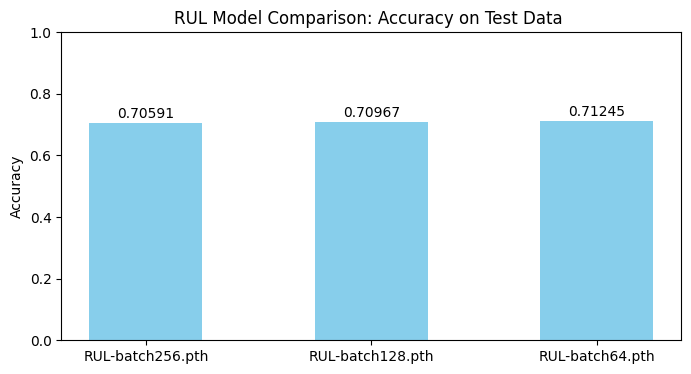

In [33]:
# 1. Plot model accuracies for comparison
plt.figure(figsize=(8, 4))
plt.bar(model_names, accuracies, color='skyblue',  width=0.5)
plt.ylim(0, 1)

for i, (model_name, accuracy) in enumerate(zip(model_names, accuracies)):
  x_pos = i  # Adjust x position if needed (e.g., for center alignment)
  y_pos = accuracy + 0.005  # Adjust y position for some space above the bar

  plt.text(x_pos, y_pos, f"{accuracy:.5f}", ha='center', va='bottom')  # Format and align the label

  plt.ylabel('Accuracy')
  plt.title('RUL Model Comparison: Accuracy on Test Data ')

plt.savefig(f'RUL Model Comparison: Accuracy on Test Data')
plt.show()

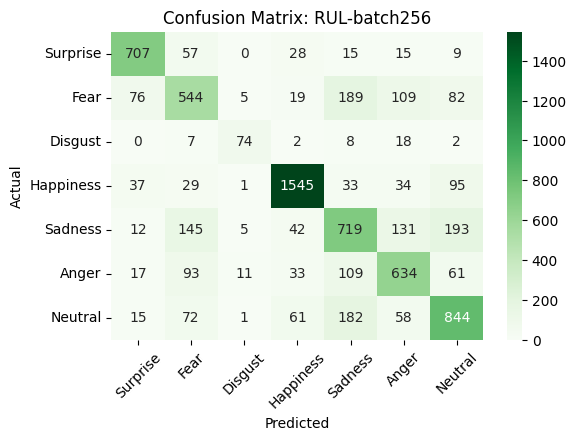

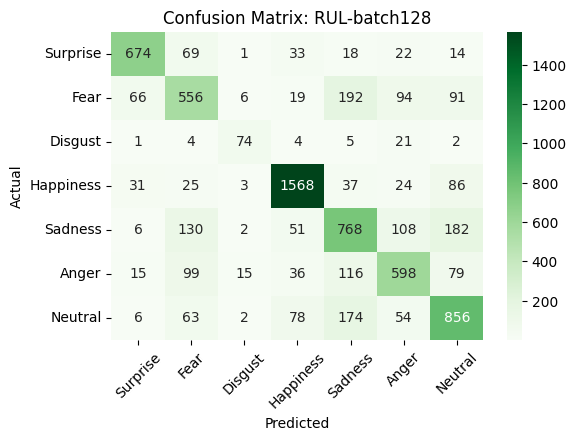

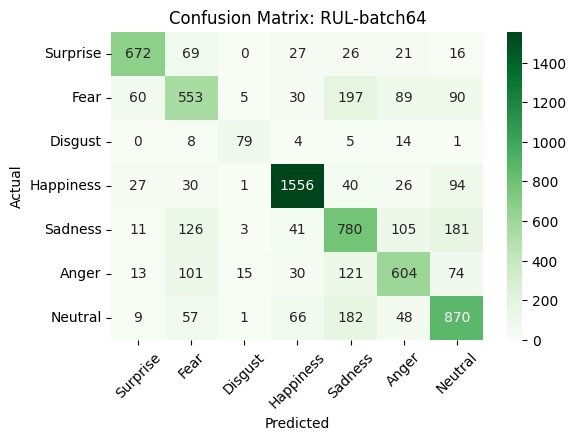

In [42]:
# 2. Plot Confusion Matrices
labels = ['Surprise' ,'Fear', 'Disgust', 'Happiness', 'Sadness', 'Anger', 'Neutral']
for i, conf_mat in enumerate(conf_mats):
    plt.figure(figsize=(6, 4))
    sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Greens', xticklabels=labels, yticklabels=labels)
    txt = model_names[i].split(".")
    plt.title(f'Confusion Matrix: {txt[0]}')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.xticks(rotation=45)
    plt.savefig(f'Confusion Matrix fernorm: {txt[0]}')
    plt.show()

In [41]:
print("rUL model class reports")
# 3. Print Classification Reports for each model
for i, class_report in enumerate(class_reports):

    class_report_df = pd.DataFrame(class_report).transpose()
    new_labels = labels
    class_report_df.index = new_labels + ['accuracy', 'macro avg', 'weighted avg']
    print("")
    print("")
    print("----------------------------------------------------")
    txt = model_names[i].split(".")
    print(f'Classification Report: {txt[0]}')
    print(class_report_df)

rUL model class reports


----------------------------------------------------
Classification Report: RUL-batch256
              precision    recall  f1-score      support
Surprise       0.818287  0.850782  0.834218   831.000000
Fear           0.574446  0.531250  0.552004  1024.000000
Disgust        0.762887  0.666667  0.711538   111.000000
Happiness      0.893064  0.870913  0.881849  1774.000000
Sadness        0.572908  0.576584  0.574740  1247.000000
Anger          0.634635  0.661795  0.647931   958.000000
Neutral        0.656299  0.684509  0.670107  1233.000000
accuracy       0.705907  0.705907  0.705907     0.705907
macro avg      0.701789  0.691786  0.696055  7178.000000
weighted avg   0.706160  0.705907  0.705702  7178.000000


----------------------------------------------------
Classification Report: RUL-batch128
              precision    recall  f1-score      support
Surprise       0.843554  0.811071  0.826994   831.000000
Fear           0.587738  0.542969  0.564467  1024.000